Welcome!

In [1]:
# %pip install -r requirements.txt
#pip installs a list of libraries
#list can be found in requirements.txt

#important import names
#import pandas as pd
#import matplotlib.pyplot as plt
#import numpy as np
#import seaborn as sns

In [ ]:
#import statements til I figure out the other way 
import nltk
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.classify import ClassifierI
nltk.download('punkt_tab')
nltk.download('tagsets')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import random
import pandas as pd
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
import json
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tabulate import tabulate
import requests
import re


In [3]:
#import sys
#sys.path.append('.')
#from importables import *
#grabs all imports from import.py

#This is not working but it should be >>>:(

In [4]:
df_elife_train = pd.read_parquet('data/Elife/train-00000-of-00001.parquet')
df_elife_test = pd.read_parquet('data/Elife/test-00000-of-00001.parquet')
df_elife_validation = pd.read_parquet('data/Elife/validation-00000-of-00001.parquet')
df_elife_validation.head(5)

article  \
0  Cell-fate reprograming is at the heart of deve...   
1  Klebsiella pneumoniae is a respiratory , blood...   
2  Plasmodium vivax relapse infections occur foll...   
3  When 2 Mha of Amazonian forests are disturbed ...   
4  Neurosphere formation is commonly used as a su...   

                                             summary  \
0  The DNA in genes encodes the basic information...   
1  Klebsiella pneumoniae is a type of bacteria th...   
2  Malaria is one of the world's most deadly infe...   
3  The Amazon rainforest in South America is the ...   
4  Neurons that arise in the adult nervous system...   

                                    section_headings  \
0  [Abstract, Introduction, Results, Discussion, ...   
1  [Abstract, Introduction, Results, Discussion, ...   
2  [Abstract, Introduction, Results, Discussion, ...   
3  [Abstract, Introduction, Results, Discussion, ...   
4  [Abstract, Introduction, Results, Discussion, ...   

                                            keywords  year  \
0                           [developmental, biology]  2016   
1  [microbiology, and, infectious, disease, immun...  2020   
2                [epidemiology, and, global, health]  2014   
3                                          [ecology]  2016   
4         [stem, cells, and, regenerative, medicine]  2014   

                                               title  
0  Increasing Notch signaling antagonizes PRC2-me...  
1  SKAP2 is required for defense against K. pneum...  
2  Modelling the contribution of the hypnozoite r...  
3  Carbon recovery dynamics following disturbance...  
4  Prospective identification of functionally dis...

In [5]:
df_plos_train_1 = pd.read_parquet('data/PLOS/train-00000-of-00003.parquet')
df_plos_train_2 = pd.read_parquet('data/PLOS/train-00001-of-00003.parquet')
df_plos_train_3 = pd.read_parquet('data/PLOS/train-00002-of-00003.parquet')
df_plos_test = pd.read_parquet('data/PLOS/test-00000-of-00001.parquet')
df_plos_validation = pd.read_parquet('data/PLOS/validation-00000-of-00001.parquet')
df_plos_train_3.head(5)

article  \
0  Cellular heterogeneity hinders the extraction ...   
1  MBT domain proteins are involved in developmen...   
2  Melioidosis is a problem in the developing tro...   
3  The recent origin and great evolutionary poten...   
4  Invariant representations of stimulus features...   

                                             summary  \
0  The mammalian inner ear is a highly complex se...   
1  Post-translational modifications ( PTM ) of hi...   
2  Melioidosis is a problem in the developing tro...   
3  The AIDS epidemic claims more lives per year t...   
4  When we physically interact with an object , o...   

                                    section_headings  \
0  [Abstract, Introduction, Results, Discussion, ...   
1  [Abstract, Introduction, Results, Discussion, ...   
2  [Abstract, Introduction, Materials, and, Metho...   
3  [Abstract, Introduction, Results, Discussion, ...   
4  [Abstract, Introduction, Results/Discussion, M...   

                                            keywords  year  \
0  [genetics, of, disease, genome, expression, an...  2011   
1  [genetic, mutation, protein, interactions, his...  2011   
2  [public, and, occupational, health, infectious...  2014   
3  [public, health, and, epidemiology/infectious,...  2009   
4  [physiology/sensory, systems, neuroscience/sen...  2010   

                                               title  
0  Cell Type‚ÄìSpecific Transcriptome Analysis Reve...  
1  H3K9me2/3 Binding of the MBT Domain Protein LI...  
2  Sulphonylurea Usage in Melioidosis Is Associat...  
3  Increasing Clinical Virulence in Two Decades o...  
4  Shape Invariant Coding of Motion Direction in ...

In [6]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [7]:
def data_cleaner(doc):
    """A function to strip punctuation, strip stopwords, casefold, lemmatize,
    And part of speech tag words for clean data for modeling"""
    custom_stops = ['doi', 'figure', 'elife', 'et', 'al']
    sw = stopwords.words('english')
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:‚Äô[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw and word not in custom_stops]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [8]:
#listifies contents in articl column
articles_list = df_elife_train.article.tolist()
print(len(articles_list))

4346


In [9]:
#print(articles_list[0])
def freqdist_maker(doc_list):
    """A function to tokenize all words in all articles"""
    doc_tokens = []
    for i in doc_list:
        doc_tokens.append(word_tokenize(i))
        
    #tokenizes raw article data into single list of tokens, not broken into sentences
    doc_tokens_flat = [word for doc in doc_tokens for word in doc]
    
    #collect raw tokens
    all_words_raw = []
    for w in doc_tokens_flat :
        all_words_raw.append(w)
    print('length of all words', len(all_words_raw))

    #gets count of tokens and types
    tokens = all_words_raw
    types = set(tokens)
    print('length of types', len(types))
    print('length of tokens', len(tokens))

    fdist1 = nltk.FreqDist(tokens)

    fdist1.plot(25, title = 'Doc Freqeuncy Distribution', cumulative = True);

In [10]:
#tokenize all words in all articles
article_tokens = []
for i in articles_list:
    article_tokens.append(word_tokenize(i))
print(len(article_tokens[0]))

3093


In [11]:
#tokenizes raw article data into single list of tokens, not broken into sentences
article_tokens_flat = [word for doc in article_tokens for word in doc]

print(article_tokens_flat[0])

In


In [12]:
#collect raw tokens
all_words_raw = []

for w in article_tokens_flat :
    all_words_raw.append(w)
    
print(len(all_words_raw))

45321232


In [13]:
#gets count of tokens and types
tokens = all_words_raw
types = set(tokens)
len(types), len(tokens)

(717066, 45321232)

In [14]:
fdist1 = nltk.FreqDist(tokens)
fdist1
#create frequency distribution, checks all tokens and how often they occur in the vocab
#prints out top 10 most used, these are usally stopwrods as the data has not been cleaned

FreqDist({'.': 2599695, ',': 2231581, 'the': 1630826, ')': 1309277, '(': 1307699, 'of': 1208012, 'and': 1052708, 'in': 821512, 'to': 619133, 'a': 471538, ...})

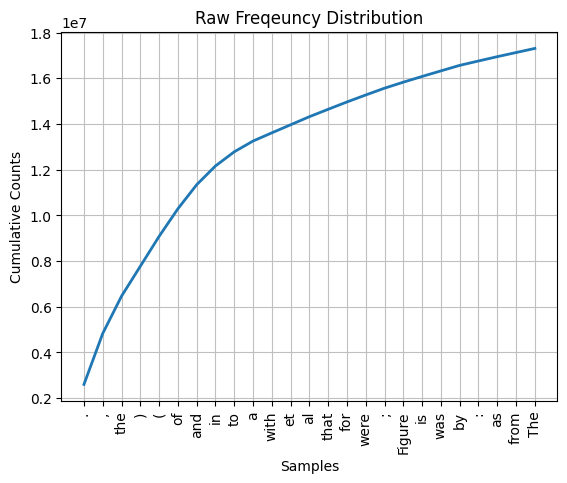

In [15]:
fdist1.plot(25, title = 'Raw Freqeuncy Distribution', cumulative = True);

In [16]:
fdist1.hapaxes()[:10]
#first ten unique words

['geo-coded',
 'June/July',
 'December/January',
 'Medina-Ram√≥n',
 'Bobb',
 'winter-summer',
 'MacDorman',
 'Lerchl',
 'always-connected',
 '15-24']

In [17]:
elife_doc_lengths = []

for doc in articles_list:
    elife_doc_lengths.append(len(doc))

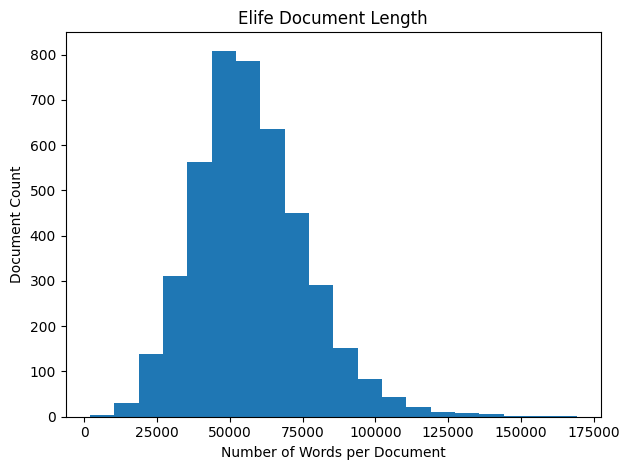

In [18]:
n_bins = 20
fig, axs = plt.subplots(1, sharey=True, tight_layout=True)
axs.hist(elife_doc_lengths, bins=n_bins)
axs.set_title("Elife Document Length");
axs.set_xlabel('Number of Words per Document');
axs.set_ylabel("Document Count");

# Data Preparation and Cleaning

The first step to our data praparation was to remove large outliers. If you look at the Elife Document Length bar graph above that at about 110000 words in length we have a handful of very lengthy documents. This will allow us to cut back on the amount of processing and time. We will also benefit from not having content from extra large documents over weighting our tf-idf scores. We removed 53 large outlier articles.

In [19]:
#code to remove documents of more than 11000 words
df_elife_train = df_elife_train[df_elife_train['article'].str.len() < 110000 ]
print(df_elife_train.shape)
articles_no_outliers = df_elife_train.article.tolist()
print(len(articles_no_outliers))

(4293, 6)
4293


One of the other problems we encountered when inspecting the data is the large amount of academic in text citations. These citations cause several issues, they're so common that they occur far more frequently than content words do, which creates extra noise. They're also full of punctuation which messes with the mechanics of the sentence tokenizer we selected. This resulted in a lot of "false" sentences. To solve these issues we removed the citations and moved the function to do so up above the more standard cleaning function. This allows us to keep our sentence index stable throughout the process while also cutting the amount of sentences per doc by almost half.

In [20]:
#initally removes things between parenthesis to keep sentence number stable in later process
def remove_between_parens(doc):
    doc = re.sub(r"\([^()]*\)|\[[^\]]*\]|\{[^}]*\}", "", doc)
    return doc

In [21]:
#run data through data parens cleaning function

no_parens_corpus = []
for doc in articles_no_outliers:
    no_parens_corpus.append(remove_between_parens(doc))
print("done")

done


To run this code on new data you will need to uncomment and run the following two cells. To recreate the exact results from our interpretation you will need to use the df_elife_train_clean.csv whcih can be located in our data folder.

In [22]:
# #runs data through data cleaning function
# run this cell unless otehrwise specified

# clean_corpus = []
# for doc in no_parens_corpus:
#     clean_corpus.append(data_cleaner(doc))
# print("done")

In [23]:
# run this cell unless otehrwise specified

# df_elife_train['clean'] = clean_corpus

# df_elife_train.head()

In [24]:
#df_elife_train.to_csv('df_elife_train_clean.csv', index=True)

In [25]:
#only run this cell if you have a copy of the cleaned training data
df_elife_train_clean = pd.read_csv('data/df_elife_train_clean.csv')
df_elife_train_clean.head()

Unnamed: 0                                            article  \
0           0  In temperate climates , winter deaths exceed s...   
1           1  Whether complement dysregulation directly cont...   
2           2  Variation in the presentation of hereditary im...   
3           3  Rapid and flexible interpretation of conflicti...   
4           4  Myosin 5a is a dual-headed molecular motor tha...   

                                             summary  \
0  In the USA , more deaths happen in the winter ...   
1  Most people have likely experienced the discom...   
2  The immune system protects an individual from ...   
3  The brain adapts to control our behavior in di...   
4  Cells use motor proteins that to move organell...   

                                    section_headings  \
0  ['Abstract', 'Introduction', 'Results', 'Discu...   
1  ['Abstract', 'Introduction', 'Results', 'Discu...   
2  ['Abstract', 'Introduction', 'Results', 'Discu...   
3  ['Abstract', 'Introduction', 'Results', 'Discu...   
4  ['Abstract', 'Introduction', 'Results', 'Discu...   

                                            keywords  year  \
0        ['epidemiology', 'and', 'global', 'health']  2018   
1  ['microbiology', 'and', 'infectious', 'disease...  2019   
2  ['microbiology', 'and', 'infectious', 'disease...  2015   
3                                   ['neuroscience']  2016   
4  ['structural', 'biology', 'and', 'molecular', ...  2015   

                                               title  \
0  National and regional seasonal dynamics of all...   
1  Complement and CD4+ T cells drive context-spec...   
2  Phenotypic complementation of genetic immunode...   
3  Cascade of neural processing orchestrates cogn...   
4  Structural dynamics of myosin 5 during process...   

                                               clean  
0  temperate climate winter death exceed summer o...  
1  whether complement dysregulation directly cont...  
2  variation presentation hereditary immunodefici...  
3  rapid flexible interpretation conflict sensory...  
4  myosin dual head molecular motor transport car...

Below are a word cloud and a frequency distribution. They show some of the more frequent words found within our data. This kind of data analysis was helpful in identifying important features in the data and looking at what we might need to strip out that isn't caught in the standard stoplist wordlist.

In [26]:
def wordcloud_maker(df, stopwords = None):
    """cretes words clouds from cleaned data"""
    all_clean = " ".join(review for review in df.clean)
    wordcloud = WordCloud(stopwords = stopwords, background_color="white").generate(all_clean)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [27]:
#wordcloud_maker(df_elife_train_clean)

length of all words 19528511
length of types 148845
length of tokens 19528511


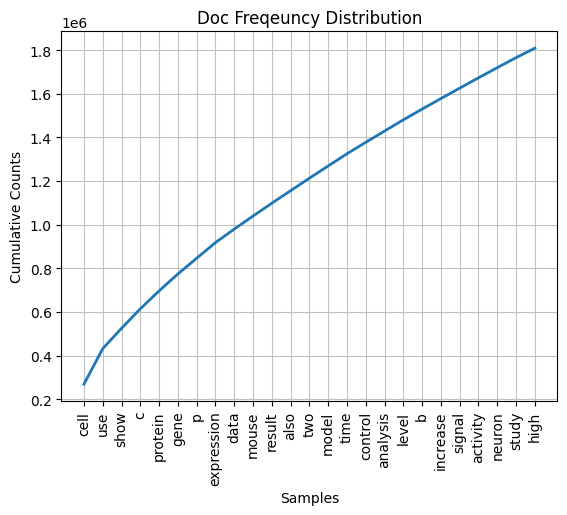

In [28]:
#checking custom stop lists and cleaning worked. Cut down 246k words
clean_doc_list = df_elife_train_clean.clean.tolist()
freqdist_maker(clean_doc_list)

# Term Frequency - Inverse Document Frequency (TF-IDF) Implementation

To begin processing our data to create extractive summaries we implement a method of assigning vectors to words called Term Frequency - Inverse Document Frequency(tf-idf). This process allows us to assign a concept of importance and meaning to words in our documents represented by a number. This is done by first getting the term frequency, a count of each term in its document divided by the total number of terms in that document. Then the inverse document frequency, which is the total number of documents in our corpus divided by the number of documents containing some specific word, that value is then multiplied by log base e. We will do this for each document to produce a unique set of vector word pairs. The higher a vector, the more important that word is to that document. 

In [29]:
# Make the TF-IDF vectorizer
vectorizer = TfidfVectorizer(analyzer = 'word', ngram_range=(1,1))

# Get the clean column from the elife dataframe
elife_train_clean = df_elife_train_clean.clean.tolist()

# Calculate the TF-IDF score for unigrams and bigrams using the clean data
elife_t_c = vectorizer.fit_transform(elife_train_clean)

#print(elife_t_c)

In [30]:
#checking for data
vocab = list(vectorizer.vocabulary_.items())
print(vocab[:5])

[('temperate', 131938), ('climate', 24423), ('winter', 145499), ('death', 32127), ('exceed', 43928)]


# Extractive Summary Creation

Once we have all of our vectors its time to start assembling our summaries. Summaries are computed by assigning every word in our data a vector and then summing those vectors up for each sentence so that each sentence in a document recieves a score. Sentences with higher scores or deemed more informative and therefore more important to the article.

In [31]:
def sentence_value_creator_2(doc_sents: list, vect_obj) -> list: # List of sentences in a document -> list of tuples (index, sum)
    """ 
    A function to take in a single article at a time, split the article by sentences, clean those sentences, split each sentence by words,
    match each word with its vector, sum the vectors and returns a list of tuples (sentence index, vector sums)
        """
    sent_index_val_dict = [] # Stores tuples (sentence_index, sum)
    for i, sent in enumerate(doc_sents): # For every index and sentence in doc_sents
        clean_sent = data_cleaner(sent) # Clean the sentence
        c = 0.0 # The vector sum (starting at 0)
        sent_split = clean_sent.split() # Split sentence by words
        for word in sent_split: # For every word in the sentence
            if word in vectorizer.vocabulary_: # If the word is in the TF-IDF vocabulary
                vec_val = vect_obj[i, vectorizer.vocabulary_[word]] # Get the vector score from TF_IDF vectorizer
                c += vec_val # Add the vector score to the total sentence score
        sent_index_val_dict.append((i,float(c))) # Append a tuple of (index, score) for the sentence 
    return sent_index_val_dict # Return the list of sentence (index, score) tuples

The following cell executes the main TF-IDF extractive summarization and saves the summaries as a new column in the df_elife_train_clean dataframe called 'tfidf_summary'. The summary_percent variable is an adjustable parameter that determines the length of the extractive summaries represented as a percentage of the original document's sentences. 

The overall process for one iteration of the for-loop (which loops through all the documents):
1) The document is sent to the method remove_between_parens to have citations and other information enclosed in parenthese removed.
2) The document is split into a list of sentences (doc_sents).
3) The extranctive summary length (number of sentences) is calculated by summary_percent*doc_length. 
4) Each sentence in the document is given a score as calculated by the sentence_value_creator_2 function. These scores are saved in a list consisting of tuples of (sentence_index, sentence_score). The sentence_index is the index of this sentence in the original doc_sents.
5) The list of tuples is sorted by score and then cropped to contain only the highest scoring top_num sentences. 
6) The list of tuples is then sorted by index so that the final summary can consist of sentences in their original order.
5) Finally, the sentences represented by the top-scoring indices are concatenated into a string, in order, and that string is added to a list of summaries as the summary for the current document.

After the loop, the list of extractive TF-IDF summaries is added as a new column in the elife training dataframe called 'tfidf_summary'. 

Once every sentence in every article has been given a score we rank them from highest to lowest, take the top 60% of sentences in proportion the original number of sentences in the article and sort them based on order of appearence in accordance to their scores.

In [32]:
summary_percent = 0.4 # Percentage of total document sentences to save as the summary
doc_summaries = [] # List to store the document summaries
doc_list = df_elife_train_clean.article.tolist() # List of all the docs in elife train


for doc in doc_list: # For every document
    no_parens = remove_between_parens(doc) # Remove citations and other parentheses from the document
    doc_sents = nltk.sent_tokenize(no_parens) # Split the document into sentences
    doc_length = len(doc_sents) # Get the total number of sentences in the document
    top_num = int(summary_percent * doc_length) # Calculate the number of sentences to keep for the summary
    sent_scores = sentence_value_creator_2(doc_sents, elife_t_c) # Get list of (index, score) pairs for all the document sentences
    sorted_scores = sorted(sent_scores, key=lambda x: x[1]) # Sort based on second tuple object; sort by score
    sorted_scores = sorted_scores[-top_num:] # Crop to just the top top_num sents
    sorted_sents = sorted(sorted_scores, key = lambda x: x[0]) # Sort the top sents by index so they are in the logical order
    doc_summary = "" # Save summary of the document as string
    for (index, score) in sorted_sents: # For every (index, score) pair
        sent = doc_sents[index] # Get the original sentence using the index
        doc_summary = doc_summary + sent + " " # Add the original sent to the full summary 
    doc_summaries.append(doc_summary) # Add the summary to the list of all summaries

# Save the summaries as a new column in the elife train dataframe
df_elife_train_clean['tfidf_summary'] = doc_summaries
    

In [33]:
# save the summaries to a csv file
df_elife_train_clean.to_csv('data/elife_summaries.csv', index=True)

# save the tfidf_summary column to a text file
with open('data/elife_summaries.txt', 'w') as f:
    for summary in df_elife_train_clean['tfidf_summary']:
        f.write(summary + '\n')


In [34]:
top_10 = df_elife_train_clean.head(10)

In [35]:
top_10

Unnamed: 0                                            article  \
0           0  In temperate climates , winter deaths exceed s...   
1           1  Whether complement dysregulation directly cont...   
2           2  Variation in the presentation of hereditary im...   
3           3  Rapid and flexible interpretation of conflicti...   
4           4  Myosin 5a is a dual-headed molecular motor tha...   
5           5  The latent reservoir is a major barrier to HIV...   
6           6  Object manufacture in insects is typically inh...   
7           7  Missense mutations of valosin-containing prote...   
8           8  Mammals produce volatile odours that convey di...   
9           9  Monocytes are phagocytic effector cells in the...   

                                             summary  \
0  In the USA , more deaths happen in the winter ...   
1  Most people have likely experienced the discom...   
2  The immune system protects an individual from ...   
3  The brain adapts to control our behavior in di...   
4  Cells use motor proteins that to move organell...   
5  There is no cure for the human immunodeficienc...   
6  Male tree crickets produce sounds at a specifi...   
7  A disease called ‚Äúinclusion body myopathy , Pa...   
8  Human body odour contains a number of chemical...   
9  White blood cells form part of the immune syst...   

                                    section_headings  \
0  ['Abstract', 'Introduction', 'Results', 'Discu...   
1  ['Abstract', 'Introduction', 'Results', 'Discu...   
2  ['Abstract', 'Introduction', 'Results', 'Discu...   
3  ['Abstract', 'Introduction', 'Results', 'Discu...   
4  ['Abstract', 'Introduction', 'Results', 'Discu...   
5  ['Abstract', 'Introduction', 'Results', 'Discu...   
6  ['Abstract', 'Introduction', 'Results', 'Discu...   
7  ['Abstract', 'Introduction', 'Results', 'Discu...   
8  ['Abstract', 'Introduction', 'Results', 'Discu...   
9  ['Abstract', 'Introduction', 'Results', 'Discu...   

                                            keywords  year  \
0        ['epidemiology', 'and', 'global', 'health']  2018   
1  ['microbiology', 'and', 'infectious', 'disease...  2019   
2  ['microbiology', 'and', 'infectious', 'disease...  2015   
3                                   ['neuroscience']  2016   
4  ['structural', 'biology', 'and', 'molecular', ...  2015   
5   ['microbiology', 'and', 'infectious', 'disease']  2020   
6  ['ecology', 'computational', 'and', 'systems',...  2017   
7                                   ['neuroscience']  2017   
8  ['structural', 'biology', 'and', 'molecular', ...  2018   
9  ['cell', 'biology', 'immunology', 'and', 'infl...  2015   

                                               title  \
0  National and regional seasonal dynamics of all...   
1  Complement and CD4+ T cells drive context-spec...   
2  Phenotypic complementation of genetic immunode...   
3  Cascade of neural processing orchestrates cogn...   
4  Structural dynamics of myosin 5 during process...   
5  Phenotypic analysis of the unstimulated in viv...   
6  Tree crickets optimize the acoustics of baffle...   
7  Valosin-containing protein (VCP/p97) inhibitor...   
8  Structural basis of malodour precursor transpo...   
9  Immune surveillance of the lung by migrating t...   

                                               clean  \
0  temperate climate winter death exceed summer o...   
1  whether complement dysregulation directly cont...   
2  variation presentation hereditary immunodefici...   
3  rapid flexible interpretation conflict sensory...   
4  myosin dual head molecular motor transport car...   
5  latent reservoir major barrier hiv cure latent...   
6  object manufacture insects typically inherit b...   
7  missense mutation valosin contain protein caus...   
8  mammal produce volatile odour convey different...   
9  monocyte phagocytic effector cell blood precur...   

                                       tfidf_summary  
0  In temperate climates , winter deaths excee

In [36]:
tfidf_top_ten = top_10.tfidf_summary.tolist()
orig_sum_top_ten = top_10.summary.tolist()

In [173]:
#tfidf_top_ten[0]

In [174]:
#orig_sum_top_ten[0]

In [176]:
summary_list = df_elife_train_clean.tfidf_summary.tolist()

In [177]:
len(summary_list)

4293

In [200]:
catch = 0
for i in summary_list:
    for j in i:
        if '\n' in j:
            #print(j)
            catch+=1
print(catch)

718


In [201]:
with open('elife_summaries.txt', 'w') as f:
    for summ in summary_list:
        f.write(summ.replace('\n','') + '\n')

In [202]:
with open('elife_summaries.txt', 'r') as g:
    lines = g.readlines()
len(lines)

4293